## 使用说明

程序自动找边界时需要手工指定边界所在的区域，为了使找到的边界更准确，在使用Canny算法时需要根据检测结果多次调整算法的参数。通过更改edge_index
来生成对应区域的mask。**注意**最后一段代码仅用于生成最右边的拼接区域。

1. 使用QGIS把原始图像转换成RGBA图像(如2015p3-qgis.tif)
2. 更改基本配置信息里的相应变量
3. 按照提示一步步执行代码
4. 生成的mask图片保存在output_dir里


## 基本配置信息

In [1]:
import os
import time
t0 = time.time()
img_path = '../input/origin/2015p3-qgis.tif'
phase = 'test'
output_dir = '../input/%s-mask/'%phase
if not os.path.exists(output_dir):
    print('Make %s.'%output_dir)
    os.makedirs(output_dir)
year = '2015'
if '2017' in img_path:
    year = '2017'

Make ../input/test-mask/.


## 读入文件并转换成灰度图像

Shape:  (4000, 15106, 4)
Type:  uint8


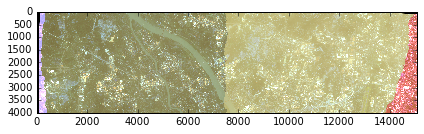

In [2]:
import skimage.io
img=skimage.io.imread(img_path)
print('Shape: ', img.shape)
print('Type: ', img.dtype)

%matplotlib inline
skimage.io.imshow(img)

## 没有黑边和拼接(可选)

In [88]:
import numpy as np
msk = np.zeros(img.shape, np.uint8)
msk[..., [0, -1]] = 255
tmp = os.path.join(output_dir, '%s%s.tif'%(year, phase))
skimage.io.imsave(tmp, msk)
print('%s has saved! '%tmp)

D:\Software\Anaconda3_Python35\lib\site-packages\skimage\io\_io.py:132: UserWarning: ../input/test-mask/2015test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


../input/test-mask/2015test.tif has saved! 


## 找边界

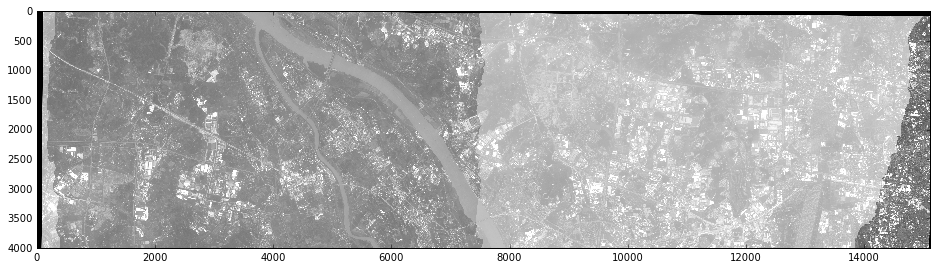

In [59]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
# img_gray = rgb2gray(img)
img_gray=img[:,:,1] # 根据实际情况选择一个通道来找边界
plt.imshow(img_gray,cmap=plt.cm.gray)

### 增大对比度(可选)

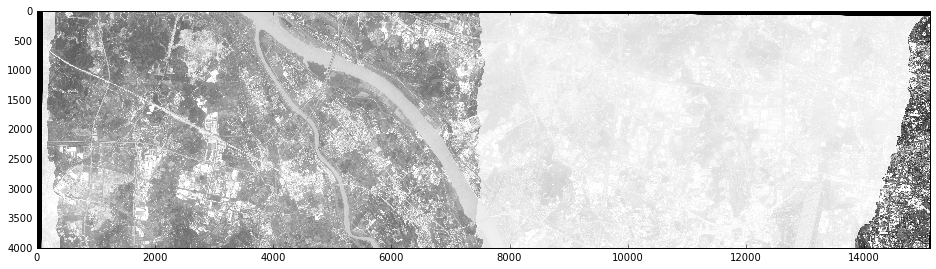

In [60]:
from skimage.exposure import adjust_sigmoid
img_gray=adjust_sigmoid(img_gray)

plt.figure(figsize=(16,12))
plt.imshow(img_gray,cmap=plt.cm.gray)

## 缩小图像

Rescaled shape:  (400, 1511)


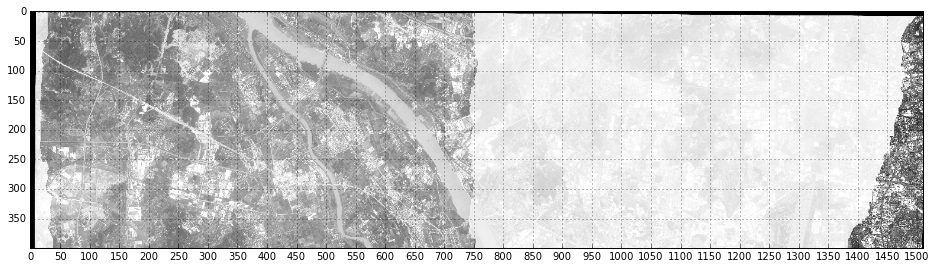

In [61]:
from skimage.transform import rescale
from matplotlib.ticker import MultipleLocator
import numpy as np

scale_value=10.0 #可根据需要调整

rescaled_grey_img=rescale(img_gray, 1.0 / scale_value)

plt.figure(figsize=(16,12))
plt.xticks(np.arange(0, rescaled_grey_img.shape[1], 50))
plt.yticks(np.arange(0, rescaled_grey_img.shape[0], 50))
plt.grid()
plt.imshow(rescaled_grey_img,cmap=plt.cm.gray)
print('Rescaled shape: ', rescaled_grey_img.shape)

## 找黑色边界的位置

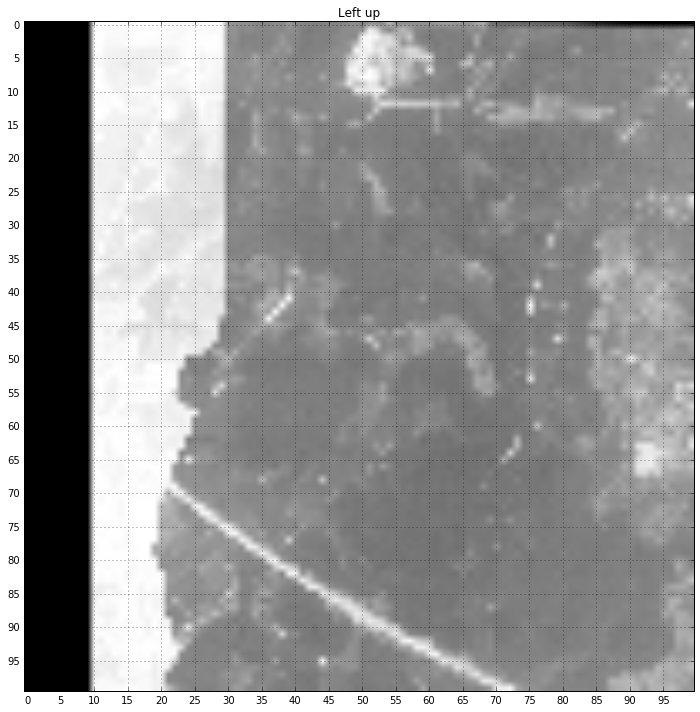

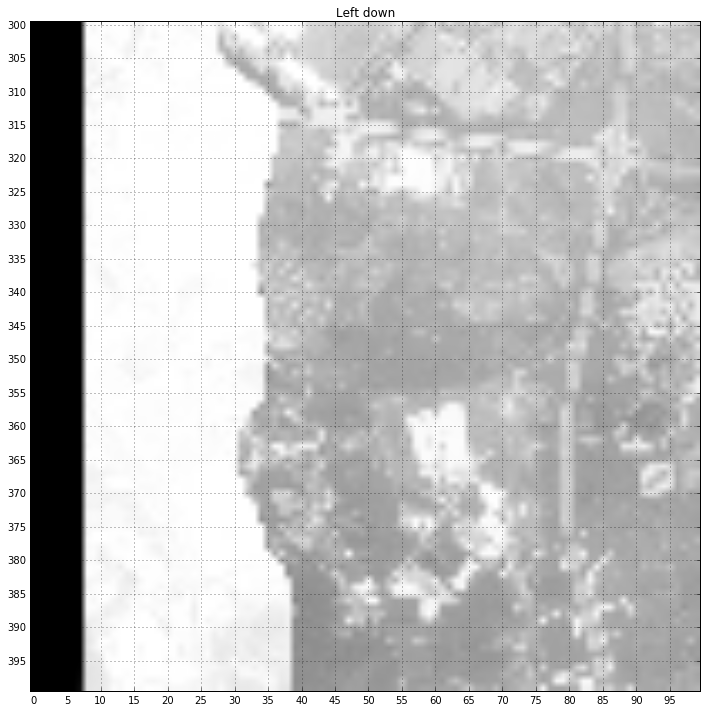

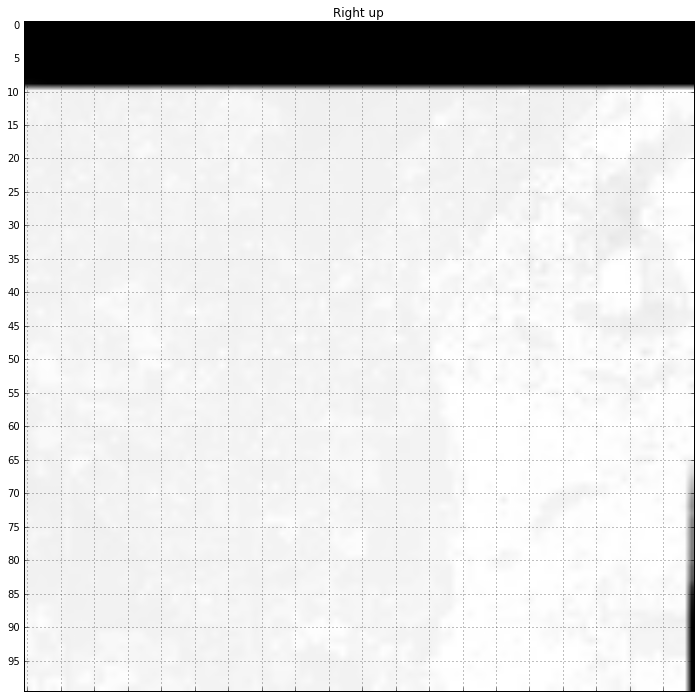

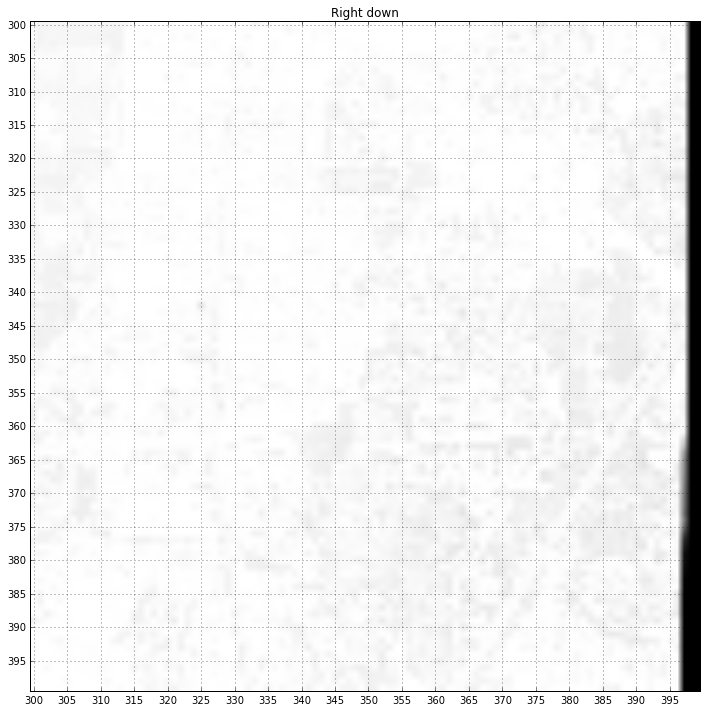

In [7]:
left_up = (100, 100)
left_down = (100, 100)
right_up = (100, 100)
right_down = (100, 100)

left_up_img = rescaled_grey_img[:left_up[0], :left_up[1]]
plt.figure(figsize=(16,12))
plt.title('Left up')
plt.xticks(np.arange(0, left_up_img.shape[1], 5))
plt.yticks(np.arange(0, left_up_img.shape[0], 5))
plt.grid()
plt.imshow(left_up_img,cmap=plt.cm.gray)

left_down_img = rescaled_grey_img[rescaled_grey_img.shape[0]-left_down[0]:, :left_down[1]]
plt.figure(figsize=(16,12))
plt.title('Left down')
plt.xticks(np.arange(0, left_down_img.shape[1], 5))
plt.yticks(np.arange(0, left_down_img.shape[0], 5), np.arange(rescaled_grey_img.shape[0]-left_down[0], rescaled_grey_img.shape[0], 5))
plt.grid()
plt.imshow(left_down_img,cmap=plt.cm.gray)

right_up_img = rescaled_grey_img[:right_up[0], rescaled_grey_img.shape[1]-right_up[1]:]
plt.figure(figsize=(16,12))
plt.title('Right up')
plt.xticks(np.arange(0, right_up_img.shape[1], 5), np.arange(rescaled_grey_img.shape[1]-right_up[0], rescaled_grey_img.shape[0], 5))
plt.yticks(np.arange(0, right_up_img.shape[0], 5))
plt.grid()
plt.imshow(right_up_img,cmap=plt.cm.gray)

right_down_img = rescaled_grey_img[rescaled_grey_img.shape[0]-right_down[0]:, rescaled_grey_img.shape[1]-right_down[1]:]
plt.figure(figsize=(16,12))
plt.title('Right down')
plt.xticks(np.arange(0, right_down_img.shape[1], 5), np.arange(rescaled_grey_img.shape[0]-right_down[0], rescaled_grey_img.shape[0], 5))
plt.yticks(np.arange(0, right_down_img.shape[0], 5), np.arange(rescaled_grey_img.shape[0]-right_down[0], rescaled_grey_img.shape[0], 5))
plt.grid()
plt.imshow(right_down_img,cmap=plt.cm.gray)


## 给定区域寻找边界

**注意**：
1. 给定区域内只能有一条边界，且边界范围越小效果越好。
2. 由于图像最左和最右侧有黑边，在起始位置和终止位置时候注意跳过几个像素      

In [8]:
black_left = int(15 * scale_value)
black_right = int(395 * scale_value)
black_up = int(15 * scale_value)
black_down = int(rescaled_grey_img.shape[0] * scale_value)
start_pos=(15,725,1375)
end_pos=(50,775,1500)

### 只有黑边无边界(可选)

In [95]:
msk = np.zeros(img.shape, np.uint8)
msk[..., [0,-1]] = 255
black_index = np.zeros(img.shape[:2], np.bool)
if black_left > 0:
    black_index[:, :black_left] = np.sum(img[:, :black_left, :-1], 2) <= 3
if black_right < img.shape[1]:
    black_index[:, black_right:] = np.sum(img[:, black_right:, :-1], 2) <= 3
if black_up > 0:
    black_index[:black_up, :] = np.sum(img[:black_up, :, :-1], 2) <= 3
if black_down < img.shape[0]:
    black_index[black_down:, :] = np.sum(img[black_down:, :, :-1], 2) <= 3
msk[black_index, 0] = 0
msk[black_index, -1] = 0
tmp = os.path.join(output_dir, '%s%s.tif'%(year, phase))
skimage.io.imsave(tmp, msk)
print('%s has saved! '%tmp)

../input/test-mask/2017test.tif has saved! 


# 依次找边界

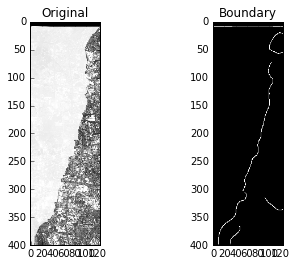

In [65]:
from skimage import feature
edge_index = 2 # 要处理的边界编号
rescaled_mini_grey_img=rescaled_grey_img[:,start_pos[edge_index]:end_pos[edge_index]]
edges = feature.canny(rescaled_mini_grey_img, 5.5) #边缘检测的参数，可调

# imshow
plt.subplot(121),plt.imshow(rescaled_mini_grey_img, cmap=plt.cm.gray),plt.title('Original')
plt.subplot(122),plt.imshow(edges, cmap=plt.cm.gray),plt.title('Boundary')
plt.show()

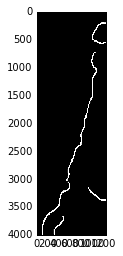

In [66]:
edges_rescaled=rescale(edges, scale_value)# 变至原来的大小
boundary = np.zeros(edges_rescaled.shape, np.bool)
boundary[black_up:black_down, :]=(edges_rescaled[black_up:black_down, :]>0) #排除黑边的影响
plt.imshow(boundary, cmap=plt.cm.gray)

In [67]:
import numpy as np

def find_true_per_row(row):
    #print(row_index)
    boundary=np.argwhere(row)#返回二维数组，每行对应着一个非零元素的坐标
    
    # whether the boundary is a serial     
    if len(boundary)>0:
        if (boundary.max()-boundary.min()+1)==len(boundary):#一行中找到的连续边界，可以删掉吧
            return boundary.min()
    return -1

boundary_col_index=np.apply_along_axis(find_true_per_row, 1, boundary).astype(np.int) # -1 ... 680 681 ...

boundary_col_index[:100]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

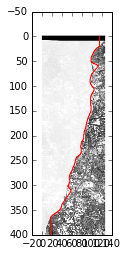

Y max: 1155, Y min: 165.


In [68]:
# 把上下两边未检测到的位置统一用最近的检测位置代替
# deal first -1s - (-1 -1) ... 680 681 ... 680 681 (-1 -1)
value=boundary_col_index[np.argmax(boundary_col_index!=-1)] 
for i in range(len(boundary_col_index)):
    if boundary_col_index[i]==-1:
        boundary_col_index[i]=value
    else:
        break
        
value=boundary_col_index[len(boundary_col_index)- np.argmax(boundary_col_index[::-1]!=-1)-1]
# deal last -1s -   -1 -1  ... 680 681 ... 680 681 (-1 -1)
for i in range(len(boundary_col_index)-1,0,-1):
    if boundary_col_index[i]==-1:
        boundary_col_index[i]=value
    else:
        break

boundary_row_index=(np.arange(len(boundary_col_index)))[boundary_col_index!=-1] # 0 1 2 ...

from scipy import interpolate
f = interpolate.interp1d(boundary_row_index, boundary_col_index[boundary_col_index!=-1])

x = np.arange(boundary_row_index.min(), boundary_row_index.max()+1, 1)
y = f(x)   # use interpolation function returned by `interp1d`
plt.imshow(rescaled_mini_grey_img, cmap=plt.cm.gray)
plt.plot( y/scale_value, x/scale_value, '-',color='r')
plt.show()
print('Y max: %d, Y min: %d.'%(y.max(), y.min()))

## 生成mask

1375
1155.0  165.0


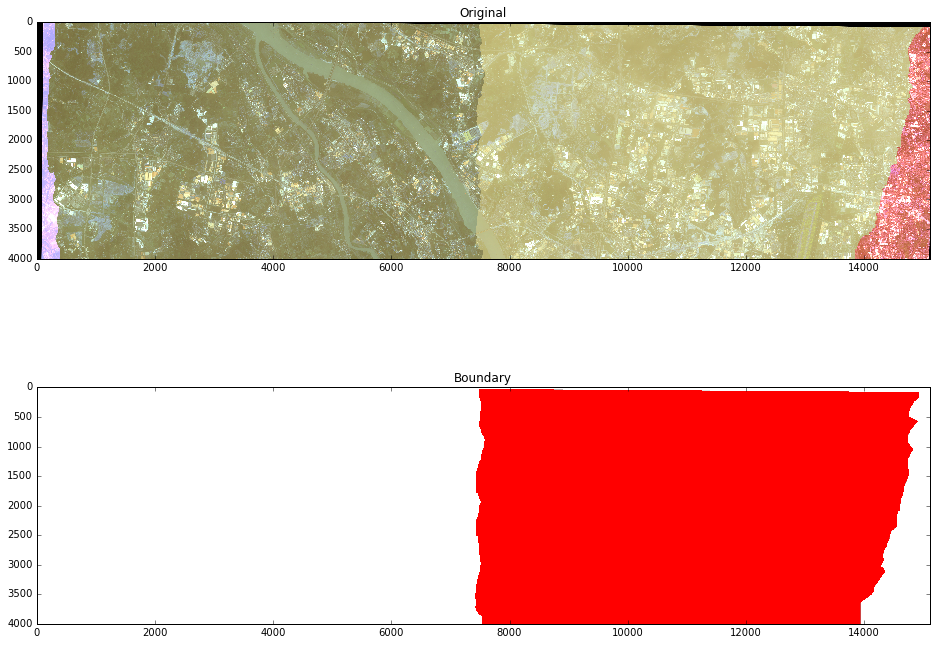

In [69]:
def find_true_per_row(row):
    #print(row_index)
    boundary=np.argwhere(row)
    
    # whether the boundary is a serial     
    if len(boundary)>0:
        if (boundary.max()-boundary.min()+1)==len(boundary):
            return boundary.min()
    return -1

def gen_mask(i):
    def f(array, row_start, row_end):
        array[row_start:row_end, [0, -1]]= 255
    return f

mask=np.zeros(img.shape[:-1]+(4,), dtype=np.uint8)
if edge_index == 0:
    mask_start_index = -1
    mask_start=np.zeros(img.shape[0], dtype=np.int)
pos = start_pos[edge_index]
print(pos)
print(y.max(), '', y.min())
y=(y+pos*scale_value).astype(np.int)

list(map(gen_mask(pos+1), mask, mask_start.tolist() , y.tolist()))
if mask_start_index != edge_index:
    mask_start=y.copy()
    mask_start_index = edge_index
black_index = np.zeros(img.shape[:2], np.bool)
if black_left > 0:
    black_index[:, :black_left] = np.sum(img[:, :black_left, :-1], 2) <= 3
if black_right < img.shape[1]:
    black_index[:, black_right:] = np.sum(img[:, black_right:, :-1], 2) <= 3
if black_up > 0:
    black_index[:black_up, :] = np.sum(img[:black_up, :, :-1], 2) <= 3
if black_down < img.shape[0]:
    black_index[black_down:, :] = np.sum(img[black_down:, :, :-1], 2) <= 3
mask[black_index, 0] = 0
mask[black_index, -1] = 0
skimage.io.imsave(os.path.join(output_dir, '%s%s-%d.tif'%(year, phase, edge_index)), mask)
#     break

# imshow
plt.figure(figsize=(16,12))
plt.subplot(211),plt.imshow(img, cmap=plt.cm.gray),plt.title('Original')
plt.subplot(212),plt.imshow(mask),plt.title('Boundary')
plt.show()

# 生成最后一块区域(仅用于最后一条边界)

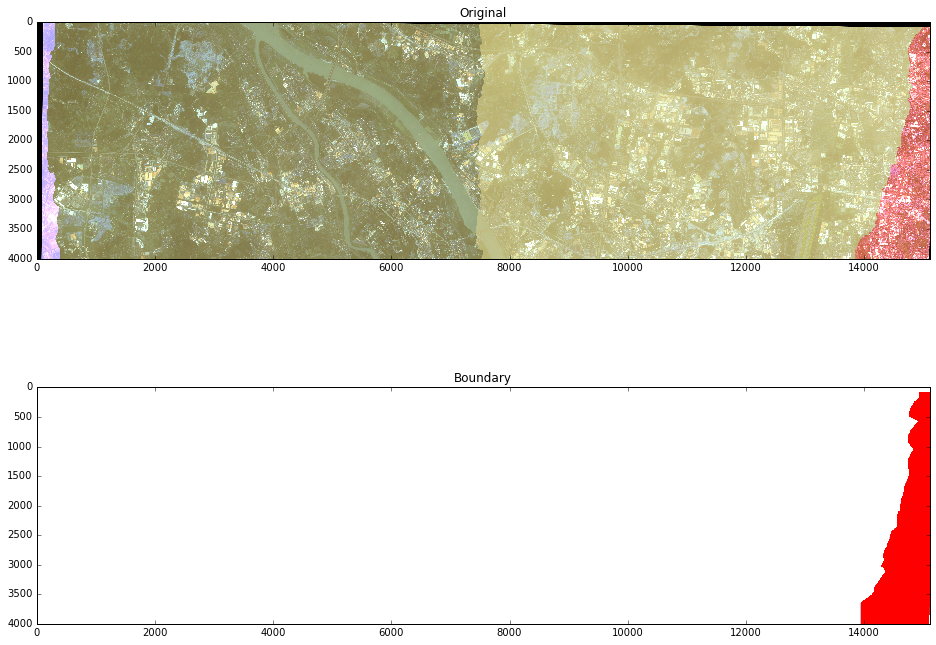

Time cost: 15.73min.


In [70]:
assert edge_index == len(start_pos)-1
mask=np.zeros(img.shape[:-1]+(4,), dtype=np.uint8)
y=np.ones(img.shape[0], np.int)*img.shape[1]

list(map(gen_mask(pos+1), mask, mask_start.tolist() , y.tolist()))
mask_start=y.copy()
black_index = np.zeros(img.shape[:2], np.bool)
if black_left > 0:
    black_index[:, :black_left] = np.sum(img[:, :black_left, :-1], 2) <= 3
if black_right < img.shape[1]:
    black_index[:, black_right:] = np.sum(img[:, black_right:, :-1], 2) <= 3
if black_up > 0:
    black_index[:black_up, :] = np.sum(img[:black_up, :, :-1], 2) <= 3
if black_down < img.shape[0]:
    black_index[black_down:, :] = np.sum(img[black_down:, :, :-1], 2) <= 3
mask[black_index, 0] = 0
mask[black_index, -1] = 0
skimage.io.imsave(os.path.join(output_dir, '%s%s-%d.tif'%(year, phase, edge_index+1)), mask)
plt.figure(figsize=(16,12))
plt.subplot(211),plt.imshow(img, cmap=plt.cm.gray),plt.title('Original')
plt.subplot(212),plt.imshow(mask),plt.title('Boundary')
plt.show()
print('Time cost: %0.2fmin.'%((time.time()-t0)/60))